# Pre-analysis of data
Here we join the files to be used in the analysis phase. We experiment with the parameters of the classifiers. We use those to classify galaxies in another notebook.
First, we import all the packages

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import astropy.units as u
from collections import Counter
import matplotlib.lines as mlines
from scipy.stats import binned_statistic
from astropy.table import Table, join, hstack

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

Additionally, we include some shortcuts to simplify some code

In [3]:
# User shortcuts
def Perc75(array):
    """75th Percentile"""
    return(np.percentile(array, 75))


def Perc25(array):
    """25th Percentile"""
    return(np.percentile(array, 25))


def CreateTableCIG(PaTable, Samp, TypeAGN):
    """Calculate the Matthwes, Cohen, F1-macro and accuracy of the results"""
    for jj in ['SKIRTOR', 'Fritz', 'S37', 'F37']:
        MCC = matthews_corrcoef(
            PaTable.loc[jj][Samp], PaTable.loc[jj][TypeAGN])
        F1s = f1_score(PaTable.loc[jj][Samp],
                       PaTable.loc[jj][TypeAGN], average='macro')
        Acc = accuracy_score(PaTable.loc[jj][Samp], PaTable.loc[jj][TypeAGN])
        print(jj, round(MCC, 3), round(F1s, 3), round(Acc, 3))


def CreateTableClas(PaTable, Samp, TypeAGN):
    """Calculate the Matthwes, Cohen, F1-macro and accuracy of the results from the Classifiers"""
    for jj in ['SKIRTOR', 'Fritz', 'S37', 'F37']:
        X = PaTable.loc[jj][Samp]
        y = PaTable.loc[jj][TypeAGN]
        x_train, x_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42)
        le = preprocessing.LabelEncoder()
        le.fit(y)
        x_train_encode = preprocessing.robust_scale(x_train)
        x_test_encode = preprocessing.robust_scale(x_test)
        y_train_encode = le.transform(y_train).reshape(-1, 1).ravel()
        y_test_encode = le.transform(y_test).reshape(-1, 1).ravel()
        # This classifiers need to be defined before use
        for iclf, Clasi in enumerate([clf_rf, clf_xg]):
            print(['RandomForest', 'XGBoost'][iclf])
            Clasi.fit(x_train_encode, y_train_encode)
            MCC = matthews_corrcoef(
                y_test_encode, Clasi.predict(x_test_encode))
            F1s = f1_score(y_test_encode, Clasi.predict(
                x_test_encode), average='macro')
            Acc = accuracy_score(y_test_encode, Clasi.predict(x_test_encode))
            print(jj, round(MCC, 3), round(F1s, 3), round(Acc, 3))
            result = permutation_importance(Clasi, x_test_encode, y_test_encode, n_repeats=20,
                                            random_state=42, n_jobs=-1)
            sorted_idx = result.importances_mean.argsort()
            print(ManualCols[sorted_idx][-4:],
                  np.mean(result.importances[sorted_idx], axis=1)[-4:])


def SelT1orT2(TableP):
    """Select Seyferts 1 and 2 in both VCV and CDS"""
    Selc1 = np.logical_and(TableP['otype_txt'] == 'Sy1', TableP['Sp'] == 'S1')
    Selc2 = np.logical_and(TableP['otype_txt'] == 'Sy2', TableP['Sp'] == 'S2')
    SelcSey = np.logical_or(Selc1, Selc2)
    return(TableP[SelcSey])

## Join all clean results

We read the results from the models we are going to use 

In [5]:
ModelS = Table.read('CIGALEOutputs/Cleanresults_SK.fits', format='fits')
ModelF = Table.read('CIGALEOutputs/Cleanresults_Fr.fits', format='fits')

ModelS37 = Table.read('CIGALEOutputs/Cleanresults_SK37.fits', format='fits')
ModelF37 = Table.read('CIGALEOutputs/Cleanresults_Fr37.fits', format='fits')

We also read the original database of galaxies, where we take the information for the classification

In [6]:
TV = Table.read('VCV_TAP_otype.txt', format='ascii')
TV.rename_column('main_id', 'id')  # Renamed to then join with the same id

We join these clean tables with the catalog. We send all the tables to pandas format. Then, we concatenate the tables to have an unique table.

In [8]:
SPandas = join(TV, ModelS, keys='id').to_pandas()
FPandas = join(TV, ModelF, keys='id').to_pandas()
SPandas37 = join(TV, ModelS37, keys='id').to_pandas()
FPandas37 = join(TV, ModelF37, keys='id').to_pandas()
SFPandas = pd.concat([SPandas, FPandas, SPandas37, FPandas37], keys=[
                     'SKIRTOR', 'Fritz', 'S37', 'F37'], names=['Model', 'idCIG'])

## Experiments with the parameters of the classifiers
We select the physical parameters in all the models and remove the ones that are not useful for our propose (e.g. constant values, young and old contributions).

In [9]:
GoodColumns = [jsd for jsd in SelT1orT2(SFPandas).columns if 'bayes' in jsd]
newdf = SelT1orT2(SFPandas)[GoodColumns]
Descr = newdf.describe()
BadCol = [js for js in newdf.columns if Descr[js]
          ['std'] < 1e-2]  # Removing constant columns
newdf = newdf.drop(BadCol, axis=1)
# Removing calculated errors
BadCol2 = [js for js in newdf.columns if '_err' in js]
newdf = newdf.drop(BadCol2, axis=1)
# Removing young estimations
BadCol3 = [js for js in newdf.columns if '_young' in js]
# Removing old estimations
BadCol4 = [js for js in newdf.columns if '_old' in js]
# Removing estimations with lines
BadCol5 = [js for js in newdf.columns if '_lines' in js]
# Removing universe values, this are dependend of redshift
BadCol6 = [js for js in newdf.columns if 'universe' in js]
# Removing filter in the attenuation modeule
BadCol7 = [js for js in newdf.columns if 'FUV' in js]
BadCols = concatenate([BadCol3, BadCol4, BadCol5, BadCol6, BadCol7])
newdf = newdf.drop(BadCols, axis=1)
newdf = newdf.dropna(axis='columns')
newdf = newdf[newdf.columns[:-31]]  # Remove the mock photometry

We split the sample of galaxies into train and test set and encode and scale the columns. 

In [9]:
X = newdf
y = SelT1orT2(SFPandas)['otype_txt']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
le = preprocessing.LabelEncoder()
le.fit(y)
x_train_encode = preprocessing.robust_scale(x_train)
x_test_encode = preprocessing.robust_scale(x_test)
y_train_encode = le.transform(y_train).reshape(-1, 1).ravel()
y_test_encode = le.transform(y_test).reshape(-1, 1).ravel()

## Using GridSearchCV to find the best parameters for the classifiers

We select two different classifiers (Random Forest and XGB). We will experiment with Grid Search. We test a model with default values and we compared with the Grid Search accuracy scoring. 

In [10]:
clf_rf = RandomForestClassifier(random_state=42)
clf_xg = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid = {"max_depth": [10, 15, 20, 25, 30, 35, 40],
              "n_estimators": [200, 400, 600, 800, 1000]}

In [13]:
# If you want to see the all verbose do not set the n_jobs=-1. They are shown in the terminal when
# the cell finish running. So for example the command should be something like
# search = GridSearchCV(clf_rf, param_grid, scoring='accuracy',
#                       verbose=4, n_jobs=-1).fit(x_train_encode, y_train_encode)
search = GridSearchCV(clf_xg, param_grid, scoring='accuracy',
                      verbose=4).fit(x_train_encode, y_train_encode)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END .................max_depth=10, n_estimators=200; total time=   3.6s
[CV 2/5] END .................max_depth=10, n_estimators=200; total time=   3.5s
[CV 3/5] END .................max_depth=10, n_estimators=200; total time=   3.5s
[CV 4/5] END .................max_depth=10, n_estimators=200; total time=   3.5s
[CV 5/5] END .................max_depth=10, n_estimators=200; total time=   3.5s
[CV 1/5] END .................max_depth=10, n_estimators=400; total time=   6.0s
[CV 2/5] END .................max_depth=10, n_estimators=400; total time=   6.0s
[CV 3/5] END .................max_depth=10, n_estimators=400; total time=   6.0s
[CV 4/5] END .................max_depth=10, n_estimators=400; total time=   6.1s
[CV 5/5] END .................max_depth=10, n_estimators=400; total time=   6.0s
[CV 1/5] END .................max_depth=10, n_estimators=600; total time=   8.0s
[CV 2/5] END .................max_depth=10, n_e

[CV 2/5] END ................max_depth=20, n_estimators=4000; total time=  24.9s
[CV 3/5] END ................max_depth=20, n_estimators=4000; total time=  24.4s
[CV 4/5] END ................max_depth=20, n_estimators=4000; total time=  24.7s
[CV 5/5] END ................max_depth=20, n_estimators=4000; total time=  24.3s
[CV 1/5] END .................max_depth=25, n_estimators=200; total time=   3.8s
[CV 2/5] END .................max_depth=25, n_estimators=200; total time=   3.8s
[CV 3/5] END .................max_depth=25, n_estimators=200; total time=   3.8s
[CV 4/5] END .................max_depth=25, n_estimators=200; total time=   3.7s
[CV 5/5] END .................max_depth=25, n_estimators=200; total time=   3.7s
[CV 1/5] END .................max_depth=25, n_estimators=400; total time=   6.0s
[CV 2/5] END .................max_depth=25, n_estimators=400; total time=   6.1s
[CV 3/5] END .................max_depth=25, n_estimators=400; total time=   6.0s
[CV 4/5] END ...............

[CV 4/5] END ................max_depth=35, n_estimators=2000; total time=  16.1s
[CV 5/5] END ................max_depth=35, n_estimators=2000; total time=  16.0s
[CV 1/5] END ................max_depth=35, n_estimators=4000; total time=  24.6s
[CV 2/5] END ................max_depth=35, n_estimators=4000; total time=  25.1s
[CV 3/5] END ................max_depth=35, n_estimators=4000; total time=  24.5s
[CV 4/5] END ................max_depth=35, n_estimators=4000; total time=  24.6s
[CV 5/5] END ................max_depth=35, n_estimators=4000; total time=  24.3s
[CV 1/5] END .................max_depth=40, n_estimators=200; total time=   3.8s
[CV 2/5] END .................max_depth=40, n_estimators=200; total time=   3.8s
[CV 3/5] END .................max_depth=40, n_estimators=200; total time=   3.8s
[CV 4/5] END .................max_depth=40, n_estimators=200; total time=   3.8s
[CV 5/5] END .................max_depth=40, n_estimators=200; total time=   3.7s
[CV 1/5] END ...............

Where the best parameters are

In [14]:
search.best_params_

({'max_depth': 35, 'n_estimators': 800},
 {'max_depth': 20, 'n_estimators': 400})

Then we use those values for the n_estimator and max_depth in these two classifiers. 

In [15]:
clf_rf2 = RandomForestClassifier(n_estimators=800, max_depth=35, random_state=42)
clf_xg2 = xgb.XGBClassifier(n_estimators=400, max_depth=20,
                            random_state=42, use_label_encoder=False, eval_metric='logloss')

##### Minor check on the calibration curve

We added a simple calibration plots to see if the probabilistic predictions of the clasifiers are calibrated. 

In [16]:
from sklearn.calibration import calibration_curve

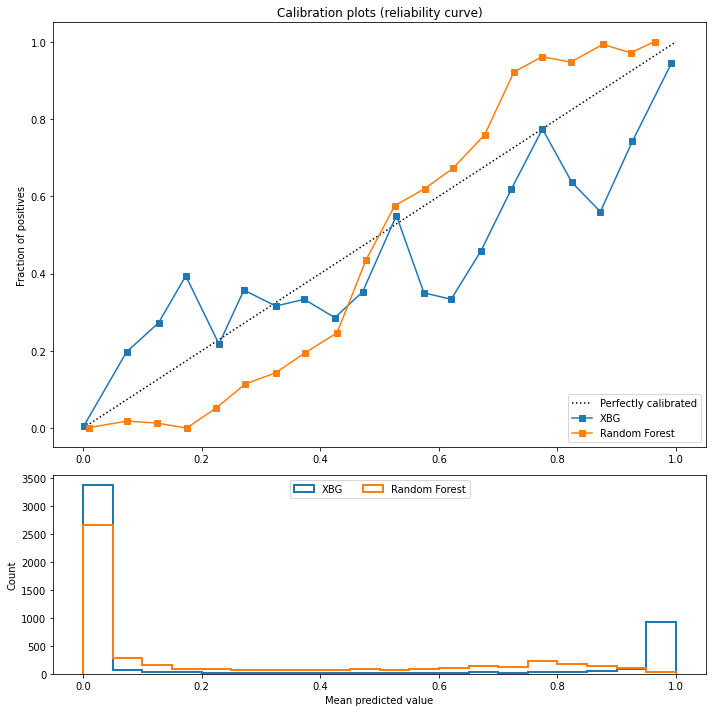

In [17]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(clf_xg2, 'XBG'),
                  (clf_rf2, 'Random Forest')]:
    clf.fit(x_train_encode, y_train_encode)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(x_test_encode)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(x_test_encode)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test_encode, prob_pos, n_bins=20)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=20, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

##### Notebook info

In [12]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
seaborn   : 0.10.1
matplotlib: 3.2.2
autopep8  : 1.5.4
numpy     : 1.19.5
logging   : 0.5.1.2
xgboost   : 1.3.3
pandas    : 1.2.0
astropy   : 4.2
json      : 2.0.9
sklearn   : 0.23.1
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
re        : 2.2.1

Watermark: 2.1.0

